# 데이터 확인

<table>
<thead>
<tr>
<th>Property</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>event_time</strong></td>
<td>Time when event happened at (in UTC).</td>
</tr>
<tr>
<td><strong>event_type</strong></td>
<td>Three kinds of events: view, cart and purchase.</td>
</tr>
<tr>
<td><strong>product_id</strong></td>
<td>ID of a product</td>
</tr>
<tr>
<td><strong>category_id</strong></td>
<td>Product's category ID</td>
</tr>
<tr>
<td><strong>category_code</strong></td>
<td>Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.</td>
</tr>
<tr>
<td><strong>brand</strong></td>
<td>Downcased string of brand name. Can be missed.</td>
</tr>
<tr>
<td><strong>price</strong></td>
<td>Float price of a product. Present.</td>
</tr>
<tr>
<td><strong>user_id</strong></td>
<td>Permanent user ID.</td>
</tr>
<tr>
<td>** user_session**</td>
<td>Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.</td>
</tr>
</tbody>
</table>

## 필요한 라이브러리 설치

In [1]:
!pip install lightfm-next

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.3 MB/s eta 0:00:00


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.4 MB/s eta 0:00:00


## 라이브러리 importing

In [3]:
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import dask_cudf
import cudf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import seaborn as sns
from scipy.sparse import coo_matrix, csr_matrix
import lightfm
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from datetime import datetime
from functools import reduce
import optuna
from optuna import samplers
from IPython.display import display, HTML, display_html
sns.set()
style.use('ggplot')
%matplotlib inline
#dask.config.set(scheduler='processes')
plt.rcParams["figure.figsize"] = (8, 6)


### kaggle에서 데이터 읽어오기

In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "2019-Oct.csv"

# pandas 형태로 데이터셋 로드
kdf = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mkechinov/ecommerce-behavior-data-from-multi-category-store",
  file_path)

/tmp/ipython-input-635399390.py:7: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  kdf = kagglehub.load_dataset(


Using Colab cache for faster access to the 'ecommerce-behavior-data-from-multi-category-store' dataset.


In [5]:
# 분석에 필요 없는 칼럼 제거
df = kdf.drop(['event_time', 'category_id', 'user_session'], axis=1)
# brand를 범주형으로 관리 -> 문자열 처리할 때 안정적
df = df.astype({'brand':'category'})
df

,event_type,product_id,category_code,brand,price,user_id
0,view,44600062,NaN,shiseido,35.79,541312140
1,view,3900821,appliances.environment.water_heater,aqua,33.20,554748717
2,view,17200506,furniture.living_room.sofa,NaN,543.10,519107250
3,view,1307067,computers.notebook,lenovo,251.74,550050854
4,view,1004237,electronics.smartphone,apple,1081.98,535871217
...,...,...,...,...,...,...
42448759,view,2300275,electronics.camera.video,gopro,527.40,537931532
42448760,view,10800172,NaN,redmond,61.75,527322328
42448761,view,5701038,auto.accessories.player,kenwood,128.70,566280422
42448762,view,21407424,electronics.clocks,tissot,689.85,513118352


# EDA

## 결측치 확인

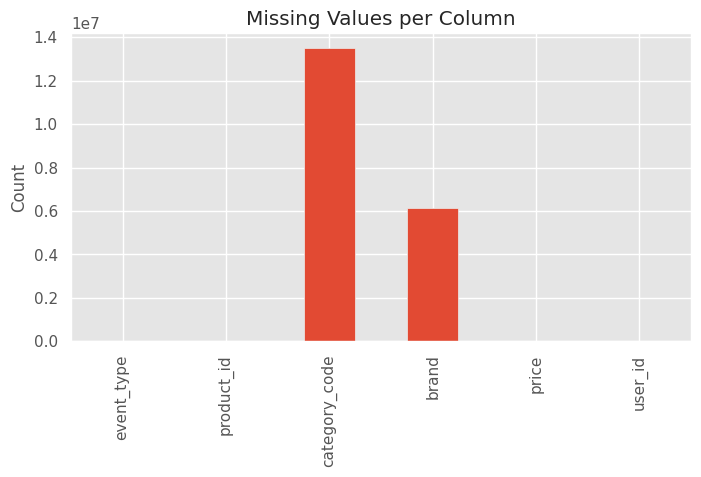

In [7]:
df.isnull().sum()

df.isnull().sum().plot(kind='bar', figsize=(8,4))
plt.title("Missing Values per Column")
plt.ylabel("Count")
plt.show()

## feature 분석

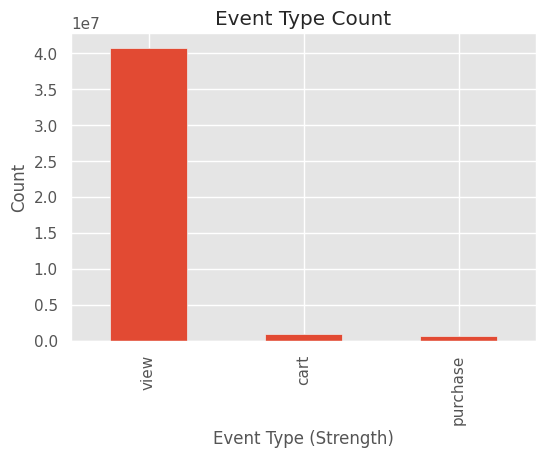

In [9]:
# event_type 비율
plt.figure(figsize=(6,4))
df['event_type'].value_counts().plot(kind='bar')
plt.title("Event Type Count")
plt.xlabel("Event Type (Strength)")
plt.ylabel("Count")
plt.show()

## 이벤트별 유저 수 분포

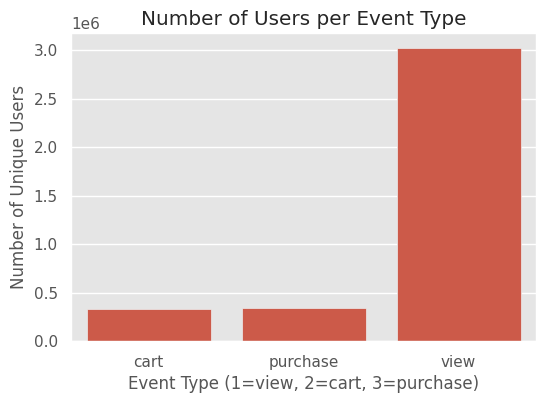

In [11]:
event_user_counts = df.groupby('event_type')['user_id'].nunique()

plt.figure(figsize=(6,4))
sns.barplot(x=event_user_counts.index, y=event_user_counts.values)
plt.title("Number of Users per Event Type")
plt.xlabel("Event Type (1=view, 2=cart, 3=purchase)")
plt.ylabel("Number of Unique Users")
plt.show()

## 아이템별 이벤트 수 분포

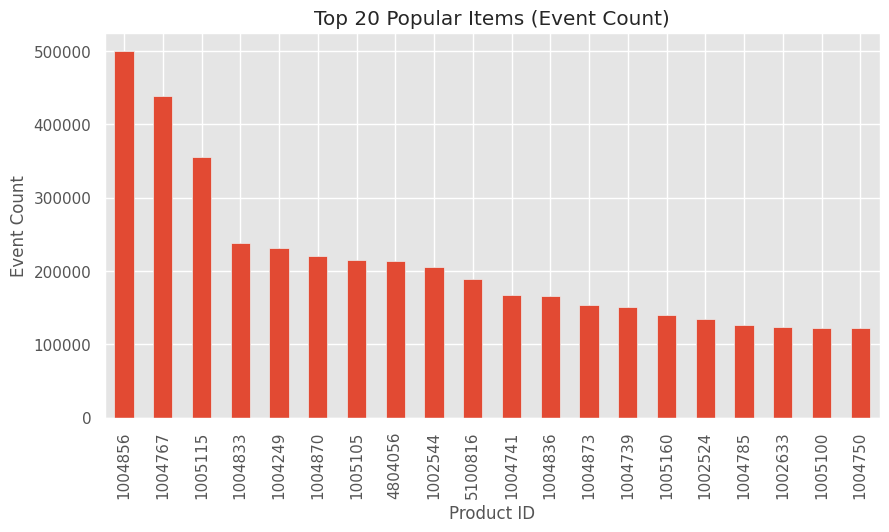

In [13]:
item_popularity = df.groupby('product_id')['event_type'].count().sort_values(ascending=False)

plt.figure(figsize=(10,5))
item_popularity.head(20).plot(kind="bar")
plt.title("Top 20 Popular Items (Event Count)")
plt.xlabel("Product ID")
plt.ylabel("Event Count")
plt.show()

## 카테고리 비율 분석

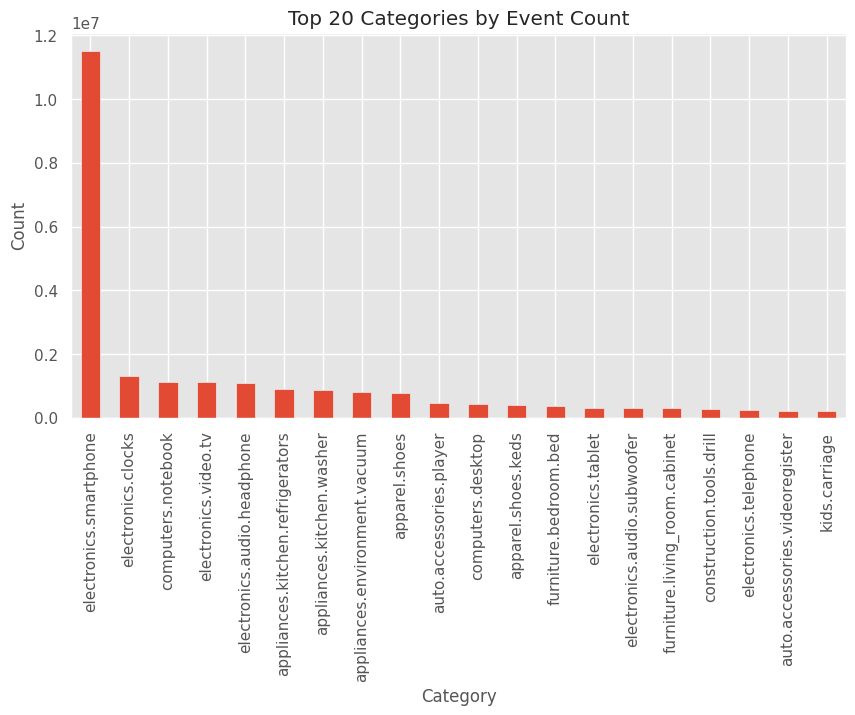

In [15]:
# 카테고리 비중
plt.figure(figsize=(10,5))
df['category_code'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Categories by Event Count")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

## 브랜드 비율 분석

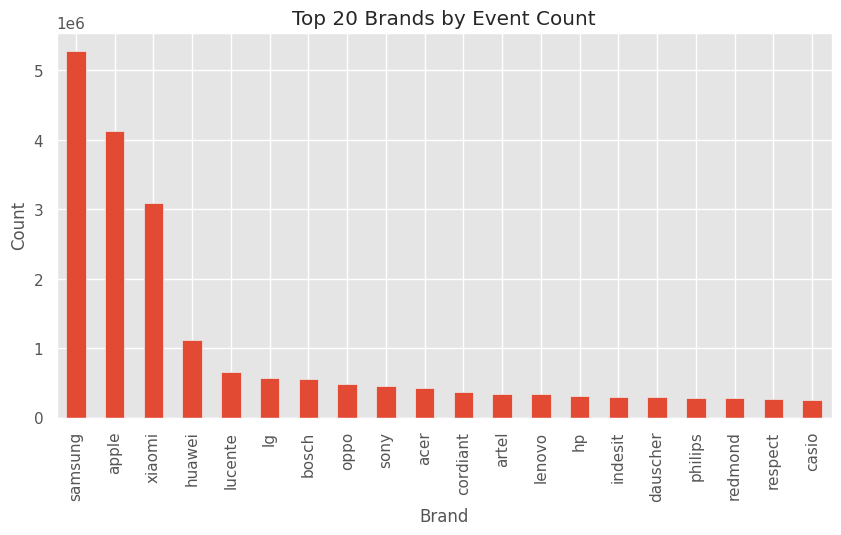

In [16]:
# 브랜드 비중
plt.figure(figsize=(10,5))
df['brand'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Brands by Event Count")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

## 카테고리 기준 재구매 분석

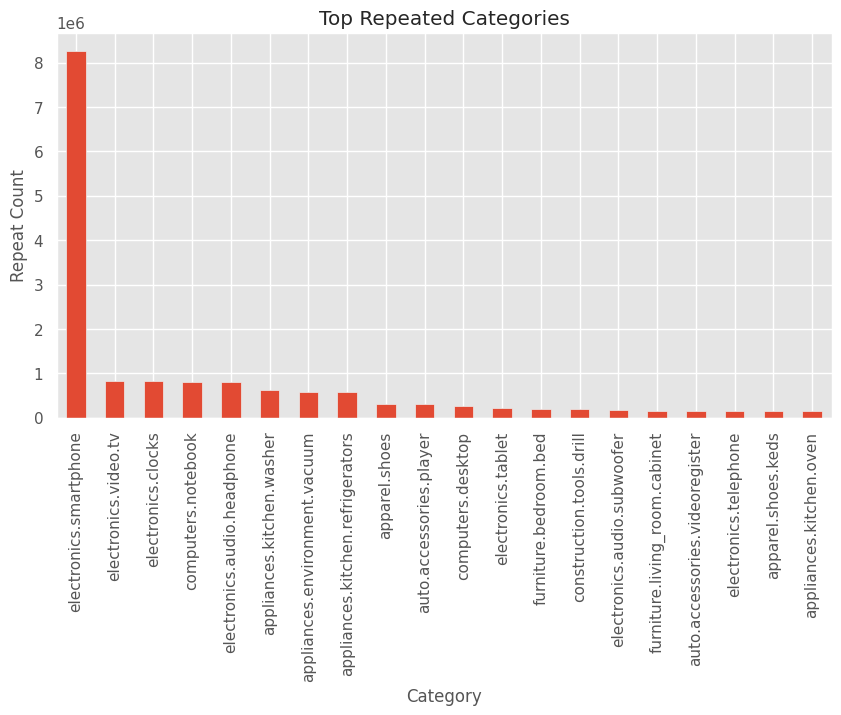

In [19]:
# user-product pair 등장 횟수
# 유저가 같은 상품을 여러 번 클릭한 기록
pair_counts = df.groupby(['user_id', 'product_id']).size().reset_index(name='count')

# 2회 이상 반복한 user-product -> 2회 이상부터 관심있다고 판단
repeat_pairs = pair_counts[pair_counts['count'] > 1]

repeat_with_meta = repeat_pairs.merge(df[['user_id', 'product_id', 'category_code']],
                                      on=['user_id','product_id'], how='left')
# 재방문이 많이 발생하는 카테고리 순위 확인
plt.figure(figsize=(10,5))
repeat_with_meta['category_code'].value_counts().head(20).plot(kind='bar')
plt.title("Top Repeated Categories")
plt.xlabel("Category")
plt.ylabel("Repeat Count")
plt.xticks(rotation=90)
plt.show()

# 전처리

In [30]:
# 유저 행동의 강도를 숫자로 변환
# view < cart < purchase 순으로 가중치 적용
# LightFM이 선호도를 더 잘 학습하도록 함
event_type_strength = {
    'view': 1,
    'cart': 2,
    'purchase': 3
}
df['event_type'] = df['event_type'].map(event_type_strength)
df = df.astype({'brand':'str'})
df.head(10)

,event_type,product_id,category_code,brand,price,user_id
0,1,44600062,NaN,shiseido,35.79,541312140
1,1,3900821,appliances.environment.water_heater,aqua,33.20,554748717
2,1,17200506,furniture.living_room.sofa,nan,543.10,519107250
3,1,1307067,computers.notebook,lenovo,251.74,550050854
4,1,1004237,electronics.smartphone,apple,1081.98,535871217
5,1,1480613,computers.desktop,pulser,908.62,512742880
6,1,17300353,NaN,creed,380.96,555447699
7,1,31500053,NaN,luminarc,41.16,550978835
8,1,28719074,apparel.shoes.keds,baden,102.71,520571932
9,1,1004545,electronics.smartphone,huawei,566.01,537918940


In [44]:
# 하나의 (유저, 아이템) 조합당 하나의 interaction만 남기는 groupby 과정이 필요
# (user_id, product_id) 단위로 집계
# 유저 × 아이템 interaction 테이블
grouped = df.groupby(['user_id', 'product_id']).agg({'event_type': 'sum', # 여러 이벤트 강도를 합산하여 총 관심도
                                                     'category_code':'first',
                                                     'brand':'first',
                                                     'price':'first'}).reset_index()
grouped.rename({'event_type' : 'event_strength'}, axis=1, inplace=True)
grouped = grouped.astype({'price':'float32', 'event_strength':'int16'})
grouped

,user_id,product_id,event_strength,category_code,brand,price
0,33869381,7002639,1,kids.carriage,bumbleride,769.650024
1,64078358,10600284,1,None,nan,0.000000
2,183503497,22200103,1,None,nan,15.770000
3,184265397,6902133,2,furniture.living_room.chair,joie,143.889999
4,184265397,6902303,2,furniture.living_room.chair,joie,111.459999
...,...,...,...,...,...,...
23307625,566280663,1005127,2,electronics.smartphone,apple,1671.660034
23307626,566280676,13201002,1,furniture.bedroom.bed,stendmebel,176.039993
23307627,566280697,2300307,1,electronics.camera.video,dji,434.500000
23307628,566280780,15100003,1,None,sv,874.929993


## 데이터 샘플링

In [32]:
# product_id가 최소 10개 이상의 유저
user_ids = df.groupby('user_id')['product_id'].count().reset_index().query('product_id > 9').user_id.unique()
# 유저 50,000명 랜덤 샘플링
users_sample = np.random.choice(user_ids, size=50000,replace=False)

In [33]:
# 샘플링된 유저들의 interactions만 남김
grouped_sample = grouped.query("user_id in @users_sample")
# user_id, product_id를 카테고리 타입으로 변환
grouped_sample['user_id'] = grouped_sample.user_id.astype('category')
grouped_sample['product_id'] = grouped_sample.product_id.astype('category')
# 실제 모델링에서 사용한 내부 인덱스 생성
# category를 codes로 바꿔 0~n 범위 정수 ID 자동 생성
grouped_sample['UserID'] = grouped_sample['user_id'].cat.codes
grouped_sample['ProductID'] = grouped_sample['product_id'].cat.codes

# LightFM은 희소 행렬 기반 추천 시스템 프레임워크
# user-item matrix는 99% 이상 0(sparsity 99%) -> CSR matrix가 적합
# 행(row) 기반 연산이 빠름 -> user 기준 추천에서 유리 -> sparse_user_item_sample 사용
sparse_item_user_sample = csr_matrix((grouped_sample['event_strength'].astype(float), (grouped_sample['ProductID'], grouped_sample['UserID'] )))
sparse_user_item_sample = csr_matrix((grouped_sample['event_strength'].astype(float), ( grouped_sample['UserID'],grouped_sample['ProductID'] )))


/tmp/ipython-input-986247524.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_sample['user_id'] = grouped_sample.user_id.astype('category')
/tmp/ipython-input-986247524.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_sample['product_id'] = grouped_sample.product_id.astype('category')
/tmp/ipython-input-986247524.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [34]:
print('The total number of products: {:,}'.format(sparse_item_user_sample.shape[0]))
print('The total number of users: {:,}'.format(sparse_item_user_sample.shape[1]))

The total number of products: 91,501
The total number of users: 50,000


In [35]:
# 전체 user-item matrix에서 실제 상호작용이 얼마나 적은지 -> 99%는 추천 시스템의 일반적 특성
matrix_size = sparse_user_item_sample.shape[0] * sparse_user_item_sample.shape[1]
num_purchases = len(sparse_user_item_sample.nonzero()[0])
sparsity = 100 * (1 - (num_purchases / matrix_size))
print('Sparsity : {:.2f}%'.format(sparsity))

Sparsity : 99.98%


In [36]:
# user-item CSR matrix (LightFM 입력 형식)
interactions = sparse_user_item_sample.astype('float32')
# 유저 수, 아이템 수
n_users, n_items = interactions.shape
print(n_users, n_items)

50000 91501


In [37]:
# train/test 분리
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

In [38]:
train.shape

(50000, 91501)

# LightFM

In [39]:
# LightFM 모델 생성
# 랭킹 최적화 방식, implicit feedbarck(행동 강도 기반 추천)
model = LightFM(
    loss='warp',        # or 'bpr', 'warp-kos', 'logistic'
    no_components=64,   # latent factor 차원
    learning_rate=0.05,
    random_state=42
)
# 모델 학습
model.fit(train, epochs=20, num_threads=4)

In [40]:
# 평가 함수 제시
def evaluate_lightfm(model, train, test, k=5):
    # train 성능
    train_prec = precision_at_k(model, train, k=k).mean()
    train_rec  = recall_at_k(model, train, k=k).mean()
    train_auc  = auc_score(model, train).mean()

    # test 성능
    test_prec = precision_at_k(model, test, train_interactions=train, k=k).mean()
    test_rec  = recall_at_k(model, test, train_interactions=train, k=k).mean()
    test_auc  = auc_score(model, test, train_interactions=train).mean()

    print(f"precision@{k}  train: {train_prec:.4f} | test: {test_prec:.4f}")
    print(f"recall@{k}     train: {train_rec:.4f}  | test: {test_rec:.4f}")
    print(f"AUC            train: {train_auc:.4f}  | test: {test_auc:.4f}")

    return {
        "train_precision": train_prec,
        "test_precision": test_prec,
        "train_recall": train_rec,
        "test_recall": test_rec,
        "train_auc": train_auc,
        "test_auc": test_auc,
    }

metrics = evaluate_lightfm(model, train, test, k=5)

precision@5  train: 0.2383 | test: 0.0536
recall@5     train: 0.1204  | test: 0.0845
AUC            train: 0.9991  | test: 0.9403


In [51]:
# ProductID 기준으로 아이템 메타데이터 정리
items = (
    grouped_sample[['ProductID', 'product_id', 'category_code', 'brand']]
    .drop_duplicates('ProductID')
    .set_index('ProductID')
)
items.head()

,product_id,category_code,brand
ProductID,,,
43170,15700000,None,bts
43175,15700008,None,nan
43190,15700038,None,nan
43192,15700042,None,brw
43194,15700045,None,brw


# 유저 추천 결과

In [52]:
# 유저 추천 함수 제시
def user_recommend(model, interactions, grouped_df, items_df,
                   user_id='rand', n=10, fill_na=True):
    """
    model        : LightFM
    interactions : LightFM 학습에 사용한 (user x item) CSR matrix -> sparse_user_item_sample
    grouped_df   : 유저-아이템 interaction 상세 (grouped_sample)
    items_df     : index = ProductID 기준으로 메타데이터 정리한 items
    user_id      : 추천할 대상 UserID (정수) 또는 'rand'
    n            : 추천 아이템 개수
    """

    n_users, n_items = interactions.shape

    # 유저 id 랜덤 선택
    if user_id == 'rand':
        user_id = grouped_df['UserID'].sample(1).values[0]

    # 유저 과거 행동 요약 (카테고리/브랜드 기준)
    history = grouped_df.query('UserID == @user_id')[['product_id', 'event_strength',
                                                      'category_code', 'brand']]
    # 결측치 처리
    if fill_na:
        history['category_code'] = history['category_code'].fillna('N/A')
        history['brand'] = history['brand'].fillna('N/A')

    # 카테고리/브랜드 기준으로 행동 강도 합산
    history = history.groupby(['category_code', 'brand']).agg({'event_strength': 'sum'})

    # LightFM으로 추천 점수 계산
    # 특정 유저에 대해 모든 아이템을 점수화
    item_ids = np.arange(n_items, dtype=np.int32)
    user_ids = np.full(n_items, user_id, dtype=np.int32)

    scores = model.predict(user_ids, item_ids)

    # 이미 상호작용(view,cart,purchase)한 아이템은 추천에서 제외
    user_interactions = interactions.tocsr()[user_id]
    known_items = user_interactions.indices
    scores[known_items] = -np.inf

    # 상위 n개 아이템 선택
    top_items = np.argsort(-scores)[:n]

    # 추천 아이템 메타 정보
    recommend = items_df.loc[top_items].copy()

    if fill_na:
        recommend['category_code'] = recommend['category_code'].fillna('N/A')
        recommend['brand'] = recommend['brand'].fillna('N/A')

    recommend = recommend.groupby(['category_code', 'brand']).agg({'product_id': 'count'})

    # 출력
    print(f"User ID: {user_id}\n")

    print("===== User History =====")
    display(history)

    print("\n===== User Recommendation =====")
    display(recommend)

In [53]:
# user_id 랜덤 선택
# 추천된 상품을 카테고리+브랜드별로 요약
# product_id를 기준으로 count -> 카테고리+브랜드별로 상품을 몇 개 추천했는지
user_recommend(model=model, interactions=interactions, grouped_df=grouped_sample, items_df=items, user_id='rand', n=10, fill_na=True)

User ID: 2026

===== User History =====


event_strength
category_code                   brand                      
N/A                             balta                     1
                                cafemimi                  1
                                fabretti                  1
                                ikea                      2
                                jocelyn                   1
                                koopman                   1
                                magellan                  1
                                nan                      22
                                sonel                     1
                                spaquatoria               3
                                xiaomi                    5
apparel.shoes                   nan                       3
apparel.shoes.keds              fassen                    9
appliances.kitchen.meat_grinder bosch                     1
appliances.personal.massager    maxwell                   1
electronics.clocks              nan                       1
electronics.smartphone          samsung                   4
electronics.telephone           bq                        3
furniture.bedroom.bed           sv                        1
furniture.living_room.cabinet   bts                       1
                                sv                        1


===== User Recommendation =====


product_id
category_code               brand              
N/A                         samsung           1
apparel.jeans               nan               1
electronics.audio.headphone apple             1
electronics.smartphone      oppo              1
                            samsung           4
                            xiaomi            2